In [98]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns

from common import *

import warnings
warnings.filterwarnings('ignore')

In [89]:
df = pd.read_csv('data/norm_sepsis_df.csv')
df = sepsis_df.iloc[:,1:]

# the goal is to use these columns to classify patients into "groups" at admission
# these variables should reflect (relatively) constant features (not dynamic over the course of treatment)

# is there race data?
# is there height data?
# should i include baseline vitals? -- HR, SysBP, DiaBP, MeanBP, RR, Temp_C
patient_group_cols = ['icustayid', 'gender', 'age', 'elixhauser', 'Weight_kg', 'SOFA']

data = df[patient_group_cols][df['initial_state'] == 1].reset_index(drop=True).values

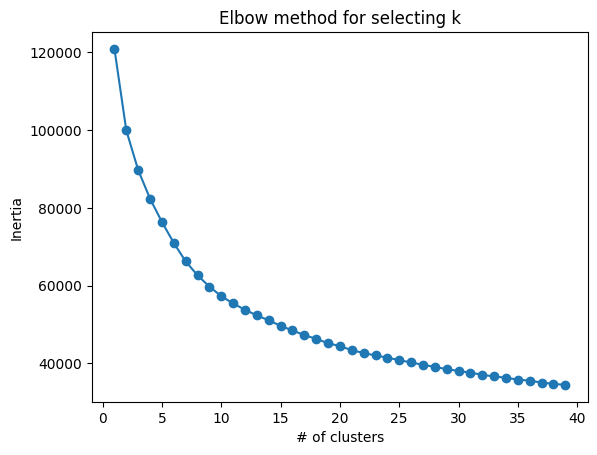

In [131]:
inertias = [] # sum of squared distance of each sample to its closest cluster centroid

for k in range(1, 40):
    kmeans = KMeans(n_clusters=k, max_iter=300, n_init=5).fit(data)
    labels = kmeans.predict(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 40), inertias, marker='o')
plt.title('Elbow method for selecting k')
plt.xlabel('# of clusters')
plt.ylabel('Inertia')
plt.show()


# for lowest inertia, I should choose k ~ 20-25
# however, I don't really care about inertia. when I have another more informative metric down the line, I should use that instead
# the higher k is, the smaller my training set will be. tradeoff between precision in patient_group and computational power

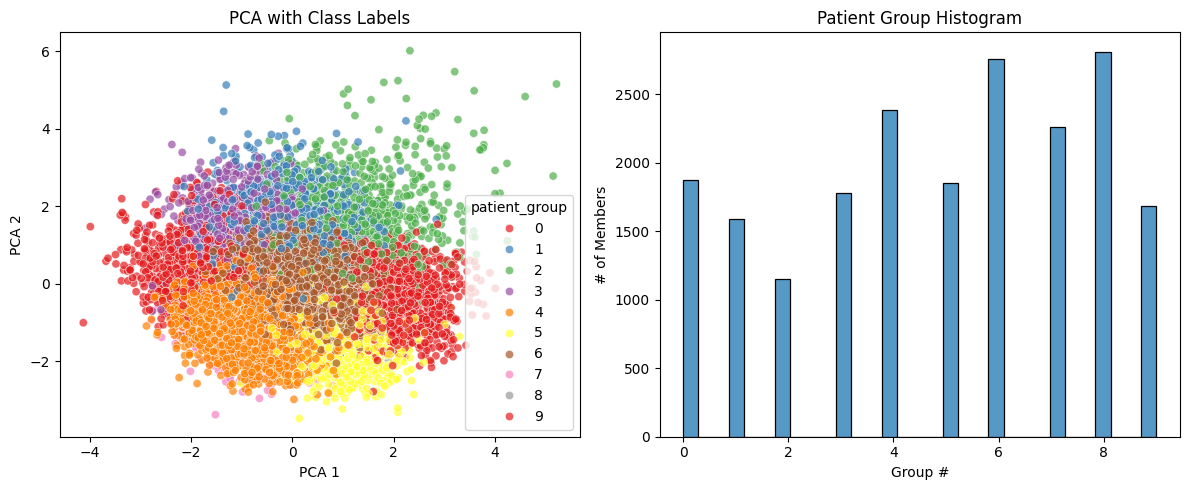

In [97]:
# this is just for visualization purposes. I should probably choose a higher value of k.

patient_groups = KMeans(n_clusters=10, max_iter=300, n_init=5).fit_predict(data)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

pca_df = pd.DataFrame(data={
    'pca_1': pca_result[:,0],
    'pca_2': pca_result[:,1],
    'patient_group': patient_groups
})

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(
    x='pca_1', y='pca_2',
    hue='patient_group',
    palette='Set1',
    data=pca_df,
    alpha=0.7,
    ax=axs[0]
)
axs[0].set_title('PCA with Class Labels')
axs[0].set_xlabel('PCA 1')
axs[0].set_ylabel('PCA 2')

sns.histplot(data=pca_df['patient_group'], ax=axs[1])
axs[1].set_title('Patient Group Histogram')
axs[1].set_xlabel('Group #')
axs[1].set_ylabel('# of Members')

plt.tight_layout()
plt.show()


In [130]:
# out of curiosity, can we use these class labels to predict SOFA score and/or mortality?

patient_groups = KMeans(n_clusters=10, max_iter=300, n_init=5).fit_predict(data)

n_samples = len(sepsis_df['icustayid'].unique())
cutoff = int(0.8 * n_samples)

sofa = sepsis_df['SOFA'][sepsis_df['initial_state'] == 1] # 24 classes
sofa_bins = np.digitize(sofa, sofa_fences)
mortality = sepsis_df['died_in_hosp'][sepsis_df['initial_state'] == 1]

print(f'Logistic Regression, predicting SOFA bin from all data: {LogisticRegression().fit(data[:cutoff], sofa_bins[:cutoff]).score(data[cutoff:], sofa_bins[cutoff:])}')

print(f'Logistic Regression, predicting SOFA bin from patient group: {LogisticRegression().fit(patient_groups[:cutoff].reshape(-1, 1), sofa_bins[:cutoff]).score(patient_groups[cutoff:].reshape(-1, 1), sofa_bins[cutoff:])}')

print(f'Logistic Regression, predicting mortality from all data: {LogisticRegression().fit(data[:cutoff], mortality[:cutoff]).score(data[cutoff:], mortality[cutoff:])}')

print(f'Logistic Regression, predicting mortality from patient_group: {LogisticRegression().fit(patient_groups[:cutoff].reshape(-1, 1), mortality[:cutoff]).score(patient_groups[cutoff:].reshape(-1, 1), mortality[cutoff:])}')

Logistic Regression, predicting SOFA bin from all data: 0.9962779156327544
Logistic Regression, predicting SOFA bin from patient group: 0.503970223325062
Logistic Regression, predicting mortality from all data: 0.8744416873449131
Logistic Regression, predicting mortality from patient_group: 0.8672456575682382


In [ ]:
# prepare a train and test dataset for each of the patient groups

In [ ]:
# run inverse RL to learn a reward function for each patient group